In [3]:
import torch
import pandas as pd
import json
# from torch.utils.data import DataLoader, SequentialSampler
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from itertools import chain
from tqdm.auto import tqdm
from pathlib import Path

from dataset import TwitterDataset
from autoencoders import load_encoder

dset = TwitterDataset(
    'timestamp',
    'sentiment/vader/',
    # whole_text_path = 'whole_text',
    # token_path = 'tokens/text',
    embedding_path = 'embeddings/all-MiniLM-L6-v2/',
)

loading from timestamp:   0%|          | 0/221 [00:00<?, ?it/s]

loading embeddings..:   0%|          | 0/221 [00:00<?, ?it/s]

loaded dataset. took 108.44935349747539 ms


In [22]:
model = load_encoder('models/LinearAutoEncoder.pkl','linear')
for p in model.parameters():
    p.requires_grad = False

In [39]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
import time

size = 1000000
model = model.cuda()

#find elbow using inertia and distortion
#use minibatch for optimal k computation to speed up calculations
cluster_count = range(2, 20)
batched_elbows = [0]*len(cluster_count)
sillhouettes = [0]*len(cluster_count)
km_multiple = [MiniBatchKMeans(n_clusters=i, max_iter=100) for i in cluster_count]

In [40]:
it_count = 0
for i in range(len(dset.embedding)):
  it_count+=1
  start = time.perf_counter()
  
  inp = dset.embedding[i*size: (i+1)*size].cuda()
  out = model.encoder(inp).cpu().numpy()
  if len(out) == 0:
    break
  
  fits = [i.fit(out) for i in km_multiple]
  inertias = [i.inertia_ for i in fits]
  #s_start = time.perf_counter()
  #s_scores = [silhouette_score(out, i.labels_) for i in fits]
  #sillhouettes = [a+b for a,b in zip(s_scores, sillhouettes)]
  #s_time = time.perf_counter()-start
  #print(s_time)
  batched_elbows = [a+b for a, b in zip(inertias, batched_elbows)]
  
  del out

  print("Iteration", it_count, f"Time taken:  {time.perf_counter()-start} seconds")
  #break
  #jsquared errors for evaluating internal consistency in clusters

Iteration 1 Time taken:  35.96688809990883 seconds
Iteration 2 Time taken:  32.67928061261773 seconds
Iteration 3 Time taken:  49.97017436847091 seconds
Iteration 4 Time taken:  36.40165319480002 seconds
Iteration 5 Time taken:  48.94588328152895 seconds
Iteration 6 Time taken:  48.940699787810445 seconds
Iteration 7 Time taken:  45.14772189036012 seconds
Iteration 8 Time taken:  36.49791792035103 seconds
Iteration 9 Time taken:  51.2301899343729 seconds
Iteration 10 Time taken:  41.354458414018154 seconds
Iteration 11 Time taken:  49.730170922353864 seconds
Iteration 12 Time taken:  36.41824891977012 seconds
Iteration 13 Time taken:  49.16570161096752 seconds
Iteration 14 Time taken:  52.5345966797322 seconds
Iteration 15 Time taken:  41.05576384626329 seconds
Iteration 16 Time taken:  41.64051019959152 seconds
Iteration 17 Time taken:  55.82613851688802 seconds
Iteration 18 Time taken:  58.028313195332885 seconds
Iteration 19 Time taken:  39.05249020643532 seconds
Iteration 20 Time t

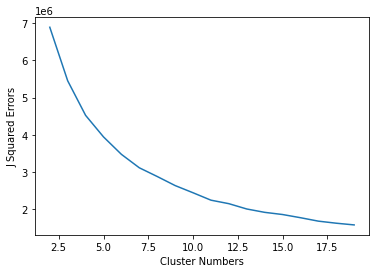

In [41]:
import matplotlib.pyplot as plt

results = [x/it_count for x in batched_elbows]
plt.plot(cluster_count, results)
plt.xlabel("Cluster Numbers")
plt.ylabel("J Squared Errors")
plt.show()

In [42]:
from kneed import KneeLocator
knee_loc = KneeLocator(range(2, 20), batched_elbows, curve="convex", direction="decreasing")
knee_loc.elbow

7

from clustering import run_kmeans

run_kmeans(
    'timestamp',
    'sentiment/vader/',
    'embeddings/all-MiniLM-L6-v2/',
    'models/LinearAutoEncoder.pkl',
    'linear',
    token_path='tokens/text',
    k = 7, 
    n = 10, 
    slice_size = '30m', 
    save_path = 'cluster_results')

In [ ]:
from sklearn.cluster import DBSCAN

batched_dbelbows = [0]*len(cluster_count)
db_multiple = [DBSCAN(n_clusters=i, max_iter=100) for i in cluster_count]